In [46]:
import numpy as np
import pandas
import pickle

In [47]:
states = np.array(pickle.load(open('../testing_scripts/gym_states.pkl', 'rb')))

In [48]:
states.max(axis=0)

array([0.30339533, 0.99986114, 5.91260531])

In [62]:
getattr(torch, 'tanh')

<function _VariableFunctions.tanh>

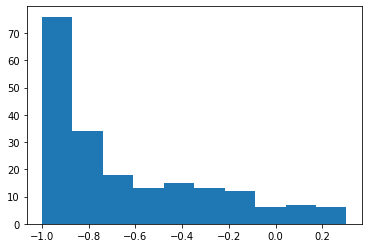

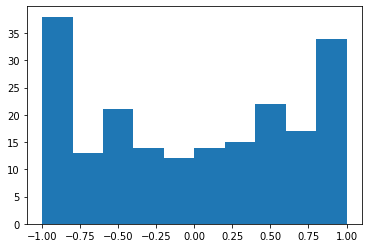

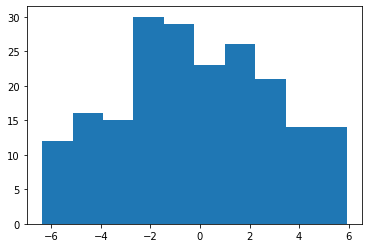

In [53]:
import matplotlib.pyplot as plt

for i in range(3):
    if i ==4:
        
        plt.hist(np.arccos(states[:,i]))
    elif i==5:
        plt.hist(np.arcsin(states[:,i]))
    else: 
        plt.hist(states[:,i])
    plt.show()

# multivariate with covariance matrix

In [54]:
mus = states.mean(axis=0)
mus

array([-0.64378526,  0.00598534, -0.16284719])

In [55]:
sigmas = np.cov(states, rowvar=False)
sigmas

array([[ 1.24720882e-01, -5.12253603e-03,  2.11855095e-02],
       [-5.12253603e-03,  4.63726063e-01, -1.00525781e-01],
       [ 2.11855095e-02, -1.00525781e-01,  9.42302880e+00]])

In [61]:
import torch
torch.distributions.MultivariateNormal(torch.Tensor(mus),torch.Tensor(sigmas) ).sample()

tensor([-0.7196,  0.6239, -2.2371])

## Independent

array([0.11866389, 0.53043727, 2.26055126])

In [34]:
torch.distributions.Normal(torch.Tensor(mus),torch.Tensor(states.std(axis=0)) ).sample()

tensor([-0.8570, -0.6774, -0.3861])